<a href="https://colab.research.google.com/github/alaahendam/AI-project/blob/master/brain_tumor_using_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data for this project is available at: https://figshare.com/articles/brain_tumor_dataset/1512427

In [0]:
!wget --no-check-certificate \
    "https://ndownloader.figshare.com/articles/1512427/versions/5" \
    -O "/tmp/brain tumor"

--2020-03-17 23:32:37--  https://ndownloader.figshare.com/articles/1512427/versions/5
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 18.203.214.185, 54.77.175.131, 52.209.237.33, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|18.203.214.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘/tmp/brain tumor’

/tmp/brain tumor    100%[===================>] 838.76M  21.1MB/s    in 42s     

2020-03-17 23:33:19 (20.1 MB/s) - ‘/tmp/brain tumor’ saved [879501695/879501695]



extract all data from brain tumor zip file

In [0]:
from zipfile import ZipFile
file_name="/tmp/brain tumor"
with ZipFile(file_name , "r")as zip2:
  zip2.extractall()
  print("done")

done


In [0]:
from zipfile import ZipFile
import os
os.mkdir('data')
list_of_files = os.listdir(os.getcwd())
for each_file in list_of_files:
  if each_file.startswith('brainTumorDataPublic_'):
    with ZipFile(each_file , "r")as zip3:
      zip3.extractall("data")
      print("done")

done
done
done
done


In [0]:
print(len(os.listdir('data')))

3064


convert matlab data to jpg image and label it

In [0]:
try:
    os.mkdir('img_data')
    os.mkdir('img_data/meningioma')
    os.mkdir('img_data/glioma')
    os.mkdir('img_data/pituitary_tumor')
except OSError:
    pass

this function i made to convert mat file in image file with label

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from PIL import Image

def convert(path , i):
      folder_name = 'img_data/'
      f = h5py.File(path, 'r') 

      cjdata = f['cjdata'] 

      image = np.array(cjdata.get('image')).astype(np.float64) 

      label = cjdata.get('label')[0,0] 

      f.close()
      hi = np.max(image)
      lo = np.min(image)
      image = (((image - lo)/(hi-lo))*255).astype(np.uint8)

      im = Image.fromarray(image)
      if label == 1:
            im.save(folder_name+'meningioma/'+str(i)+'.jpg') 
      elif label == 2:
            im.save(folder_name+'glioma/'+str(i)+'.jpg')    
      elif label == 3:
            im.save(folder_name+'pituitary_tumor/'+str(i)+'.jpg') 

In [0]:
IMG_PATH = 'data/'
i = 0
# split the data by train/val/test
for file in os.listdir(IMG_PATH):
    if not file.startswith('.'):
        convert(IMG_PATH + '/' + file , i)
        i += 1

In [0]:
print(len(os.listdir('img_data/meningioma')))
print(len(os.listdir('img_data/glioma')))
print(len(os.listdir('img_data/pituitary_tumor')))

708
1426
930


In [0]:
try:
    os.mkdir('TRAIN')
    os.mkdir('TRAIN/meningioma')
    os.mkdir('TRAIN/glioma')
    os.mkdir('TRAIN/pituitary_tumor')
    os.mkdir('TEST')
    os.mkdir('TEST/meningioma')
    os.mkdir('TEST/glioma')
    os.mkdir('TEST/pituitary_tumor')
    os.mkdir('VAL')
    os.mkdir('VAL/meningioma')
    os.mkdir('VAL/glioma')
    os.mkdir('VAL/pituitary_tumor')
except OSError:
    pass

we equalize the amount of images that are used to train the CNN for each class or type of tumors. Out of all available images, we only used 700 images from each class where 500 of those images were used for training phase and the other 150 images were used for validation phase and the other 150 images were used for testing phase like this [paper](https://link.springer.com/chapter/10.1007/978-981-10-9035-6_33?fbclid=IwAR2lMgRjg024v9man9XFGvv2Q26yi7CPZkX4yBV1nONKq1CazjFCDg9-yKI)

In [0]:
import shutil
IMG_PATH = 'img_data/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 50:
                shutil.copy(img, 'TEST/' + CLASS + '/' + FILE_NAME)
            elif n < 550:
                shutil.copy(img, 'TRAIN/'+ CLASS + '/' + FILE_NAME)
            elif n < 700:
                shutil.copy(img, 'VAL/'+ CLASS+ '/' + FILE_NAME)

In [0]:
print(len(os.listdir('TRAIN/meningioma')))
print(len(os.listdir('TEST/meningioma')))
print(len(os.listdir('VAL/meningioma')))

500
50
150


The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [0]:
def crop_imgs(path):
      img = cv2.imread(path)
      img = cv2.resize(
                  img,
                  dsize=IMG_SIZE,
                  interpolation=cv2.INTER_CUBIC
              )
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      gray = cv2.GaussianBlur(gray, (5, 5), 0)

      # threshold the image, then perform a series of erosions +
      # dilations to remove any small regions of noise
      thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
      thresh = cv2.erode(thresh, None, iterations=2)
      thresh = cv2.dilate(thresh, None, iterations=2)

      # find contours in thresholded image, then grab the largest one
      cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = imutils.grab_contours(cnts)
      c = max(cnts, key=cv2.contourArea)

      # find the extreme points
      extLeft = tuple(c[c[:, :, 0].argmin()][0])
      extRight = tuple(c[c[:, :, 0].argmax()][0])
      extTop = tuple(c[c[:, :, 1].argmin()][0])
      extBot = tuple(c[c[:, :, 1].argmax()][0])


      # crop
      ADD_PIXELS = 0
      new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
      return new_img 

In [0]:
try:
    os.mkdir('CROP_TRAIN')
    os.mkdir('CROP_TRAIN/meningioma')
    os.mkdir('CROP_TRAIN/glioma')
    os.mkdir('CROP_TRAIN/pituitary_tumor')
    os.mkdir('CROP_TEST')
    os.mkdir('CROP_TEST/meningioma')
    os.mkdir('CROP_TEST/glioma')
    os.mkdir('CROP_TEST/pituitary_tumor')
    os.mkdir('CROP_VAL')
    os.mkdir('CROP_VAL/meningioma')
    os.mkdir('CROP_VAL/glioma')
    os.mkdir('CROP_VAL/pituitary_tumor')
except OSError:
    pass

In [0]:
!pip install imutils
import shutil
import cv2
import imutils
IMG_SIZE = (224,224)
TRAIN_IMG_PATH = 'TRAIN/'
TEST_IMG_PATH = 'TEST/'
VAL_IMG_PATH = 'VAL/'
# split the data by train/val/test
for CLASS in os.listdir(TRAIN_IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(TRAIN_IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(TRAIN_IMG_PATH + CLASS)):
            img = TRAIN_IMG_PATH + CLASS + '/' + FILE_NAME
            X_train_crop = crop_imgs(path=img)
            cv2.imwrite('CROP_TRAIN/' + CLASS + '/' + FILE_NAME, X_train_crop)


for CLASS in os.listdir(TEST_IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(TEST_IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(TEST_IMG_PATH + CLASS)):
            img = TEST_IMG_PATH + CLASS + '/' + FILE_NAME
            X_train_crop = crop_imgs(path=img)
            cv2.imwrite('CROP_TEST/' + CLASS + '/' + FILE_NAME, X_train_crop)


for CLASS in os.listdir(VAL_IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(VAL_IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(VAL_IMG_PATH + CLASS)):
            img = VAL_IMG_PATH + CLASS + '/' + FILE_NAME
            X_train_crop = crop_imgs(path=img)
            cv2.imwrite('CROP_VAL/' + CLASS + '/' + FILE_NAME, X_train_crop)                                    

In [0]:
print(len(os.listdir('CROP_TRAIN/meningioma')))
print(len(os.listdir('CROP_TEST/meningioma')))
print(len(os.listdir('CROP_VAL/meningioma')))

500
50
150


In [0]:
import cv2
img = cv2.imread('img_data/pituitary_tumor/1006.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

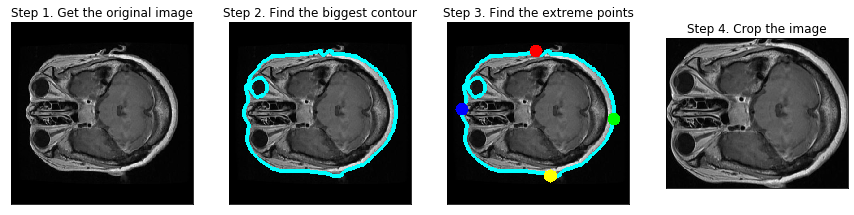

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [0]:
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
TRAINING_DIR = "CROP_TRAIN/"
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range=[0.5, 1.5],
                                   vertical_flip=True,)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    color_mode='rgb',
                                                    batch_size=50,
                                                    class_mode='categorical',
                                                    target_size=(224,224))


VALIDATION_DIR = "CROP_VAL/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              color_mode='rgb',
                                                              batch_size=30,
                                                              class_mode='categorical',
                                                              target_size=(224,224))

Found 1500 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


In [0]:
from keras.applications.vgg16 import VGG16
pre_trained_model3 = VGG16(input_shape=(224,224,3), 
                                include_top = False,
                                weights='imagenet')





58892288/58889256 [==============================] - 2s 0us/step








In [0]:
for layer in pre_trained_model3.layers[:15]:
   layer.trainable = False
for layer in pre_trained_model3.layers[15:]:
   layer.trainable = True

In [0]:
model3 = models.Sequential()
model3.add(pre_trained_model3)
model3.add(layers.Dropout(0.3))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(3, activation='softmax'))

model3.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Tota

In [0]:
model3.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model3.stop_training = True

In [0]:
callbacks = myCallback()

after 20 epochs i decrease learning rate from 0.0003 to 0.0002

In [0]:
history = model3.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 60,
            epochs = 20,
            validation_steps = 40,
            callbacks=[callbacks])

Epoch 1/20
60/60 [==============================] - 43s 709ms/step - loss: 0.1604 - acc: 0.9410 - val_loss: 0.2473 - val_acc: 0.9225
Epoch 2/20
60/60 [==============================] - 41s 676ms/step - loss: 0.1346 - acc: 0.9540 - val_loss: 0.2412 - val_acc: 0.9358
Epoch 3/20
60/60 [==============================] - 41s 677ms/step - loss: 0.1271 - acc: 0.9527 - val_loss: 0.2238 - val_acc: 0.9342
Epoch 4/20
60/60 [==============================] - 41s 682ms/step - loss: 0.1226 - acc: 0.9503 - val_loss: 0.2428 - val_acc: 0.9458
Epoch 5/20
60/60 [==============================] - 41s 682ms/step - loss: 0.1269 - acc: 0.9500 - val_loss: 0.2575 - val_acc: 0.9317
Epoch 6/20
60/60 [==============================] - 41s 683ms/step - loss: 0.1199 - acc: 0.9577 - val_loss: 0.3025 - val_acc: 0.9275
Epoch 7/20
60/60 [==============================] - 41s 690ms/step - loss: 0.1022 - acc: 0.9623 - val_loss: 0.2273 - val_acc: 0.9417
Epoch 8/20
60/60 [==============================] - 41s 683ms/step - 

AttributeError: ignored

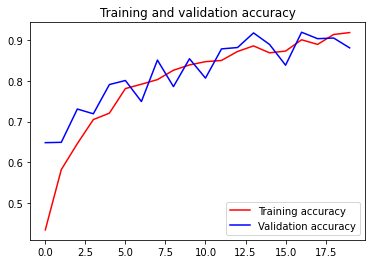

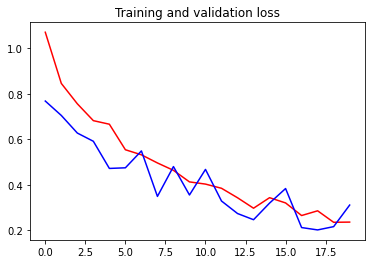

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.show()

In [0]:
scores = model3.evaluate_generator(validation_generator,workers=12)
scores

[0.18195195719599724, 0.953333322207133]

In [0]:
test_data_dir = 'CROP_TEST/'

test_datagen = ImageDataGenerator(
    rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=10,
	shuffle=False,
    class_mode='categorical')

#Evaluate model on test set
scores = model3.evaluate_generator(test_generator,workers=12)

Found 150 images belonging to 3 classes.


In [0]:
scores

[0.2634944233103132, 0.9666666626930237]

In [0]:
test_generator.reset()
Y_pred = model3.predict_generator(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==classes)/10000
print(sum(y_pred==classes))
0.9922

from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes[test_generator.index_array],y_pred)

145


array([[50,  0,  0],
       [ 4, 45,  1],
       [ 0,  0, 50]])

In [0]:
from keras.preprocessing import image
import numpy as np

# dimensions of our images    -----   are these then grayscale (black and white)?
img_width, img_height = 224,224

# Get test image ready
test_image = image.load_img('CROP_TEST/glioma/1118.jpg', target_size=(img_width, img_height))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

test_image = test_image.reshape(1,img_width, img_height,3)    # Ambiguity!
# Should this instead be: test_image.reshape(img_width, img_height, 3) ??

result = model3.predict(test_image, batch_size=1)
print (result)

[[1. 0. 0.]]


In [0]:
saved_model_path = "./brain_tumor_model.h5"
model3.save(saved_model_path)